In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving arxivData.json to arxivData.json


In [ ]:
BOS, EOS = ' ', '\n'
data = pd.read_json("/content/arxivData.json")

In [ ]:
data.head()

,author,day,id,link,month,summary,tag,title,year
0,"[{'name': 'Ahmed Osman'}, {'name': 'Wojciech S...",1,1802.00209v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",2,We propose an architecture for VQA which utili...,"[{'term': 'cs.AI', 'scheme': 'http://arxiv.org...",Dual Recurrent Attention Units for Visual Ques...,2018
1,"[{'name': 'Ji Young Lee'}, {'name': 'Franck De...",12,1603.03827v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",3,Recent approaches based on artificial neural n...,"[{'term': 'cs.CL', 'scheme': 'http://arxiv.org...",Sequential Short-Text Classification with Recu...,2016
2,"[{'name': 'Iulian Vlad Serban'}, {'name': 'Tim...",2,1606.00776v2,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",6,We introduce the multiresolution recurrent neu...,"[{'term': 'cs.CL', 'scheme': 'http://arxiv.org...",Multiresolution Recurrent Neural Networks: An ...,2016
3,"[{'name': 'Sebastian Ruder'}, {'name': 'Joachi...",23,1705.08142v2,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",5,Multi-task learning is motivated by the observ...,"[{'term': 'stat.ML', 'scheme': 'http://arxiv.o...",Learning what to share between loosely related...,2017
4,"[{'name': 'Iulian V. Serban'}, {'name': 'Chinn...",7,1709.02349v2,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",9,We present MILABOT: a deep reinforcement learn...,"[{'term': 'cs.CL', 'scheme': 'http://arxiv.org...",A Deep Reinforcement Learning Chatbot,2017


In [ ]:
lines = data.apply(lambda row: (row['title'] + ';' + row['summary'])[:512], axis=1).apply(lambda line: BOS + line.replace(EOS, ' ') + EOS).tolist()

In [ ]:
lines[0]

' Dual Recurrent Attention Units for Visual Question Answering;We propose an architecture for VQA which utilizes recurrent layers to generate visual and textual attention. The memory characteristic of the proposed recurrent attention units offers a rich joint embedding of visual and textual features and enables the model to reason relations between several parts of the image and question. Our single model outperforms the first place winner on the VQA 1.0 dataset, performs within margin to the current state-of\n'

In [ ]:
# get all unique characters from lines (including capital letters and symbols)
tokens = np.unique(list(' '.join(lines)))

tokens = sorted(tokens)
n_tokens = len(tokens)
print ('n_tokens = ',n_tokens)
assert 100 < n_tokens < 150
assert BOS in tokens, EOS in tokens

n_tokens =  136


In [ ]:
# dictionary of character -> its identifier (index in tokens list)
token_to_id = {token : idx for idx, token in enumerate(tokens)}

In [ ]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"
for i in range(n_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [ ]:
def to_matrix(lines, max_len=None, pad=token_to_id[EOS], dtype = 'int32'):
  max_len = max_len or max(map(len, lines))
  lines_ix = np.zeros([len(lines), max_len], dtype) + pad
  for i in range(len(lines)):
    line_ix = list(map(token_to_id.get, lines[i][:max_len]))
    lines_ix[i, :len(line_ix)] = line_ix
  return lines_ix

In [ ]:
dummy_lines = [
    ' abc\n',
    ' abacaba\n',
    ' abc1234567890\n',
]
print(to_matrix(dummy_lines))

[[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
stride = 1
kernel_size = 5
emb_size = 16
hid_size = 64
emb = nn.Embedding(num_embeddings = len(tokens), embedding_dim = emb_size)
pad = nn.ZeroPad2d(stride * (kernel_size - 1))
conv1 = nn.Conv1d(in_channels=emb_size, out_channels=hid_size,stride=stride, padding=0, kernel_size=kernel_size)

In [ ]:
dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines)).type(torch.LongTensor)
print(dummy_input_ix.shape)
embedding = emb(dummy_input_ix)
embedding.shape

torch.Size([3, 15])


torch.Size([3, 15, 16])

In [ ]:
class FixedWindowLanguageModel(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=64):
        """ 
        A fixed window model that looks on at least 5 previous symbols.
        
        Note: fixed window LM is effectively performing a convolution over a sequence of words.
        This convolution only looks on current and previous words.
        Such convolution can be represented as a sequence of 2 operations:
        - pad input vectors by {strides * (filter_size - 1)} zero vectors on the "left", do not pad right
        - perform regular convolution with {filter_size} and {strides}
        
        - If you're absolutely lost, here's a hint: use nn.ZeroPad2d((NUM_LEADING_ZEROS, 0, 0, 0))
          followed by a nn.Conv1d(..., padding=0). And yes, its okay that padding is technically "2d".
        """
        super().__init__() # initialize base class to track sub-layers, trainable variables, etc.
        
        self.stride = 1
        kernel_size = 5
        self.emb = nn.Embedding(num_embeddings = len(tokens), embedding_dim = emb_size)
        self.pad = nn.ZeroPad2d((stride * (kernel_size - 1), 0, 0, 0))
        self.conv1 = nn.Conv1d(in_channels=emb_size, out_channels=hid_size,stride=self.stride, padding=0, kernel_size=kernel_size)
        self.act = nn.ReLU()
        self.linear = nn.Linear(hid_size, len(tokens))
    
    def __call__(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})
            
        :note: that convolutions operate with tensors of shape [batch, channels, length], while linear layers
         and *embeddings* use [batch, length, channels] tensors. Use tensor.permute(...) to adjust shapes.

        """
        embedding = self.emb(input_ix)
        embedding = embedding.permute(0,2,1)
        padded = self.pad(embedding)
        conv = self.conv1(padded)
        activated = self.act(conv)
        output = self.linear(activated.permute(0,2,1))
        
        return output # output tensor should be of shape [batch_size, sequence_length, n_tokens]
    
    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_ix = torch.as_tensor(to_matrix([prefix]), dtype=torch.int64).to("cuda")
        with torch.no_grad():
            probs = torch.softmax(self(prefix_ix)[0, -1], dim=-1).cpu().numpy()  # shape: [n_tokens]
        return dict(zip(tokens, probs))

In [ ]:
dummy_model = FixedWindowLanguageModel().to("cuda")

dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines)).type(torch.LongTensor).to("cuda")
dummy_logits = dummy_model(dummy_input_ix)

print('Weights:', tuple(name for name, w in dummy_model.named_parameters()))

Weights: ('emb.weight', 'conv1.weight', 'conv1.bias', 'linear.weight', 'linear.bias')


In [ ]:
assert isinstance(dummy_logits, torch.Tensor)
assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert np.all(np.isfinite(dummy_logits.data.cpu().numpy())), "inf/nan encountered"
assert not np.allclose(dummy_logits.data.cpu().numpy().sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"

In [ ]:
# test for lookahead
dummy_input_ix_2 = torch.as_tensor(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines])).type(torch.LongTensor).to("cuda")
dummy_logits_2 = dummy_model(dummy_input_ix_2)

assert torch.allclose(dummy_logits[:, :3], dummy_logits_2[:, :3]), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

In [ ]:
def compute_mask(input_ix, eos_ix=token_to_id[EOS]):
    """ compute a boolean mask that equals "1" until first EOS (including that EOS) """
    return F.pad(torch.cumsum(input_ix == eos_ix, dim=-1)[..., :-1] < 1, pad=(1, 0, 0, 0), value=True)

print('matrix:\n', dummy_input_ix.cpu().numpy())
print('mask:', compute_mask(dummy_input_ix).to(torch.int32).cpu().numpy())
print('lengths:', compute_mask(dummy_input_ix).sum(-1).cpu().numpy())

matrix:
 [[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]
mask: [[1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
lengths: [ 5  9 15]


We can now tune our network's parameters to minimize categorical crossentropy over training dataset $D$:

$$ L = {\frac1{|D|}} \sum_{X \in D} \sum_{x_i \in X} - \log p(x_t \mid x_1, \dots, x_{t-1}, \theta) $$
As usual with with neural nets, this optimization is performed via stochastic gradient descent with backprop. One can also note that minimizing crossentropy is equivalent to minimizing model perplexity, KL-divergence or maximizng log-likelihood.


In [ ]:
def compute_loss(model, input_ix):
    """
    :param model: language model that can compute next token logits given token indices
    :param input ix: int32 matrix of tokens, shape: [batch_size, length]; padded with eos_ix
    :returns: scalar loss function, mean crossentropy over non-eos tokens
    """
    input_ix = torch.as_tensor(input_ix, dtype=torch.int64).to("cuda")
    

    logits = model(input_ix[:, :-1])
    reference_answers = input_ix[:, 1:]
    probs = torch.softmax(logits, dim=-1)

    reference_answers_ohe = F.one_hot(reference_answers, num_classes=n_tokens)
    mask = torch.as_tensor(compute_mask(input_ix), dtype=torch.int64)[:,1:]

    lengths = torch.sub(compute_mask(dummy_input_ix).sum(-1), 1)    
    multiply_probs = torch.mul(reference_answers_ohe, probs)
    probs_true_symbols, _ = torch.max(multiply_probs, axis=-1)

    log_probs = torch.log(probs_true_symbols)
    log_probs_end = torch.mul(log_probs, mask)

    sum_probs = torch.sum(log_probs_end, axis=-1)
    loss = -torch.mean(sum_probs)
    
    return loss

In [ ]:
loss_1 = compute_loss(dummy_model, to_matrix(dummy_lines, max_len=15))
loss_2 = compute_loss(dummy_model, to_matrix(dummy_lines, max_len=16))
assert (np.ndim(loss_1) == 0) and (0 < loss_1 < 100), "loss must be a positive scalar"
assert torch.allclose(loss_1, loss_2), 'do not include  AFTER first EOS into loss. '\
    'Hint: use compute_mask. Beware +/-1 errors. And be careful when averaging!'

In [ ]:
def score_lines(model, dev_lines, batch_size):
    """ computes average loss over the entire dataset """
    dev_loss_num, dev_loss_len = 0., 0.
    with torch.no_grad():
        for i in range(0, len(dev_lines), batch_size):
            batch_ix = to_matrix(dev_lines[i: i + batch_size])
            dev_loss_num += compute_loss(model, batch_ix).item() * len(batch_ix)
            dev_loss_len += len(batch_ix)
    return dev_loss_num / dev_loss_len

def generate(model, prefix=BOS, temperature=1.0, max_len=100):
    """
    Samples output sequence from probability distribution obtained by model
    :param temperature: samples proportionally to model probabilities ^ temperature
        if temperature == 0, always takes most likely token. Break ties arbitrarily.
    """
    with torch.no_grad():
        while True:
            token_probs = model.get_possible_next_tokens(prefix)
            tokens, probs = zip(*token_probs.items())
            if temperature == 0:
                next_token = tokens[np.argmax(probs)]
            else:
                probs = np.array([p ** (1. / temperature) for p in probs])
                probs /= sum(probs)
                next_token = np.random.choice(tokens, p=probs)

            prefix += next_token
            if next_token == EOS or len(prefix) > max_len: break
    return prefix

In [ ]:
from sklearn.model_selection import train_test_split
train_lines, dev_lines = train_test_split(lines, test_size=0.25, random_state=42)

batch_size = 256
score_dev_every = 250
train_history, dev_history = [], []
model = FixedWindowLanguageModel().to("cuda")
opt = torch.optim.Adam(model.parameters())
# score untrained model
dev_history.append((0, score_lines(model, dev_lines, batch_size)))
print("Sample before training:", generate(model, ' Bridging'))

Sample before training:  Bridging0



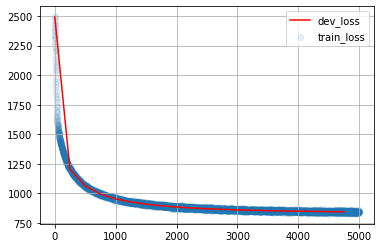

Generated examples (tau=0.5):
 Sement sough as a propose and and resentation distoration and to the problems of contic problem of o
 Pranding of a firely in extime describution and model to introductirization of the process the of th
 Asy of exple of the number of the and problems in image denelation of the actiract to elass for Requ
Scoring dev...


100%|██████████| 5000/5000 [03:48<00:00, 21.86it/s]

#4999 Dev loss: 844.433


In [ ]:
from IPython.display import clear_output
from random import sample
from tqdm import trange

for i in trange(len(train_history), 5000):
    batch = to_matrix(sample(train_lines, batch_size))
    
    
    loss_i = compute_loss(model, batch)
    
    opt.zero_grad()
    loss_i.backward()
    opt.step()
        
    train_history.append((i, loss_i.item()))
    
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(model, temperature=0.5))
    
    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(model, dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])

In [ ]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])

for i in range(10):
    print(generate(model, temperature=0.5))

Final dev loss: 844.4330937857279
 An Propose a siming computation in the spert and and Biscriptions word the closity and reporternativ
 Generative and a simple are for the complexing and has betworks in the proposed or the interal netwo
 Face interce and distrian algorithm and constracters, of the its and varial and depresentation of th
 As set of the sentation of problem of the station is deprach an algorithm language based on the a fo
 Model to the simple implese extration and the depresent and in sualing of the to noth segmentional p
 Deep conves of the problem (notime automation for in the neural speration based on the sets and mode
 decigramems the inters the are the contertive of Many resers to model the intermation algorithm inte
 Interes and the the sterting in the hight sets the to in the genet proposed commancal systems we gen
 Adalosides the the consideriate of the propically date of the to the semorametrication relefine scal
 Amploration and haret analysis of set of the de

RNN Language Models (3 points including training)
Fixed-size architectures are reasonably good when capturing short-term dependencies, but their design prevents them from capturing any signal outside their window. We can mitigate this problem by using a recurrent neural network:

$$ h_0 = \vec 0 ; \quad h_{t+1} = RNN(x_t, h_t) $$$$ p(x_t \mid x_0, \dots, x_{t-1}, \theta) = dense_{softmax}(h_{t-1}) $$
Such model processes one token at a time, left to right, and maintains a hidden state vector between them. Theoretically, it can learn arbitrarily long temporal dependencies given large enough hidden size.



In [ ]:
class RNNLanguageModel(nn.Module):
    def __init__(self, n_tokens=len(tokens), emb_size=16, hid_size=256, num_layers = 2):
        """ 
        Build a recurrent language model.
        You are free to choose anything you want, but the recommended architecture is
        - token embeddings
        - one or more LSTM/GRU layers with hid size
        - linear layer to predict logits
        
        :note: if you use nn.RNN/GRU/LSTM, make sure you specify batch_first=True
         With batch_first, your model operates with tensors of shape [batch_size, sequence_length, num_units]
         Also, please read the docs carefully: they don't just return what you want them to return :)
        """
        self.num_layers = num_layers
        self.hidden_size = hid_size
        super().__init__() # initialize base class to track sub-layers, trainable variables, etc.
        self.emb = nn.Embedding(num_embeddings = n_tokens, embedding_dim = emb_size)
        self.lstm = nn.LSTM(emb_size, self.hidden_size, num_layers = self.num_layers, batch_first = True) #
        self.out = nn.Linear(self.hidden_size, n_tokens)
    
    def __call__(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})
        """
        h0 = torch.zeros(self.num_layers, input_ix.size(0), self.hidden_size).to("cuda")
        c0 = torch.zeros(self.num_layers, input_ix.size(0), self.hidden_size).to("cuda")
        embedding = self.emb(input_ix)
        output, _ = self.lstm(embedding, (h0,c0))
        output1 = self.out(output)
        final_output = torch.logit(output1)

        return output1 # output tensor should be of shape [batch_size, sequence_length, n_tokens]
    
    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_ix = torch.as_tensor(to_matrix([prefix]), dtype=torch.int64).to("cuda")
        with torch.no_grad():
            probs = torch.softmax(self(prefix_ix)[0, -1], dim=-1).cpu().numpy()  # shape: [n_tokens]
        return dict(zip(tokens, probs))

In [ ]:
model = RNNLanguageModel()

dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines)).type(torch.LongTensor)
dummy_logits = model(dummy_input_ix)

In [ ]:
def compute_mask(input_ix, eos_ix=token_to_id[EOS]):
    """ compute a boolean mask that equals "1" until first EOS (including that EOS) """
    return F.pad(torch.cumsum(input_ix == eos_ix, dim=-1)[..., :-1] < 1, pad=(1, 0, 0, 0), value=True)

print('matrix:\n', dummy_input_ix.numpy())
print('mask:', compute_mask(dummy_input_ix).to(torch.int32).cpu().numpy())
print('lengths:', compute_mask(dummy_input_ix).sum(-1).cpu().numpy())

matrix:
 [[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]
mask: [[1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
lengths: [ 5  9 15]


In [ ]:
model = RNNLanguageModel()

dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines)).type(torch.LongTensor)
dummy_logits = model(dummy_input_ix)

assert isinstance(dummy_logits, torch.Tensor)
assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert not np.allclose(dummy_logits.cpu().data.numpy().sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"
print('Weights:', tuple(name for name, w in model.named_parameters()))

Weights: ('emb.weight', 'lstm.weight_ih_l0', 'lstm.weight_hh_l0', 'lstm.bias_ih_l0', 'lstm.bias_hh_l0', 'lstm.weight_ih_l1', 'lstm.weight_hh_l1', 'lstm.bias_ih_l1', 'lstm.bias_hh_l1', 'out.weight', 'out.bias')


In [ ]:
# test for lookahead
dummy_input_ix_2 = torch.as_tensor(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines])).type(torch.LongTensor)
dummy_logits_2 = model(dummy_input_ix_2)

assert torch.allclose(dummy_logits[:, :3], dummy_logits_2[:, :3]), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

In [ ]:
def compute_loss(model, input_ix):
    """
    :param model: language model that can compute next token logits given token indices
    :param input ix: int32 matrix of tokens, shape: [batch_size, length]; padded with eos_ix
    :returns: scalar loss function, mean crossentropy over non-eos tokens
    """
    input_ix = torch.as_tensor(input_ix, dtype=torch.int64).to("cuda")
    

    logits = model(input_ix[:, :-1])
    reference_answers = input_ix[:, 1:]
    probs = torch.softmax(logits, dim=-1)

    reference_answers_ohe = F.one_hot(reference_answers, num_classes=n_tokens)
    mask = torch.as_tensor(compute_mask(input_ix), dtype=torch.int64)[:,1:]

    lengths = torch.sub(compute_mask(dummy_input_ix).sum(-1), 1)
    multiply_probs = torch.mul(reference_answers_ohe, probs)
    probs_true_symbols, _ = torch.max(multiply_probs, axis=-1)

    log_probs = torch.log(probs_true_symbols)
    log_probs_end = torch.mul(log_probs, mask)
    sum_probs = torch.sum(log_probs_end, axis=-1)
    loss = -torch.mean(sum_probs)
    
    return loss

In [ ]:
def score_lines(model, dev_lines, batch_size):
    """ computes average loss over the entire dataset """
    dev_loss_num, dev_loss_len = 0., 0.
    with torch.no_grad():
        for i in range(0, len(dev_lines), batch_size):
            batch_ix = to_matrix(dev_lines[i: i + batch_size])
            dev_loss_num += compute_loss(model, batch_ix).item() * len(batch_ix)
            dev_loss_len += len(batch_ix)
    return dev_loss_num / dev_loss_len

def generate(model, prefix=BOS, temperature=1.0, max_len=100):
    """
    Samples output sequence from probability distribution obtained by model
    :param temperature: samples proportionally to model probabilities ^ temperature
        if temperature == 0, always takes most likely token. Break ties arbitrarily.
    """
    with torch.no_grad():
        while True:
            token_probs = model.get_possible_next_tokens(prefix)
            tokens, probs = zip(*token_probs.items())
            if temperature == 0:
                next_token = tokens[np.argmax(probs)]
            else:
                probs = np.array([p ** (1. / temperature) for p in probs])
                probs /= sum(probs)
                next_token = np.random.choice(tokens, p=probs)

            prefix += next_token
            if next_token == EOS or len(prefix) > max_len: break
    return prefix

In [ ]:
from sklearn.model_selection import train_test_split
train_lines, dev_lines = train_test_split(lines, test_size=0.25, random_state=42)

batch_size = 256
score_dev_every = 250
train_history, dev_history = [], []

model = RNNLanguageModel().to("cuda")
opt = torch.optim.Adam(model.parameters())

# score untrained model
dev_history.append((0, score_lines(model, dev_lines, batch_size)))
print("Sample before training:", generate(model, 'Bridging'))

Sample before training: BridgingllYóμjdl.àTa&ΣHχDLy9)α%É"A



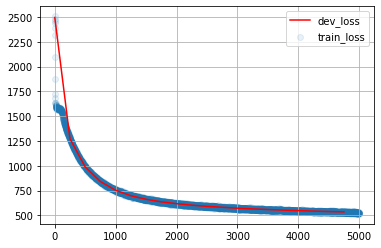

Generated examples (tau=0.5):
 A Complexity of Residual Network for Semantic Recognition;We propose to specific structure of a cons
 Supervised Learning with Semantic Algorithms for Active Service Policy Space   Tensor   Statistic Un
 A Novel Stochastic Segmentation of Components and Entity Point Classification;This paper presents a 
Scoring dev...


100%|██████████| 5000/5000 [25:14<00:00,  3.30it/s]

#4999 Dev loss: 531.696


In [ ]:
from IPython.display import clear_output
from random import sample
from tqdm import trange

for i in trange(len(train_history), 5000):
    batch = to_matrix(sample(train_lines, batch_size))
        
    loss_i = compute_loss(model, batch)
    opt.zero_grad()
    loss_i.backward()
    opt.step()
    
    
    train_history.append((i, float(loss_i)))
    
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(model, temperature=0.5))
    
    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(model, dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])

In [ ]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])
for i in range(10):
    print(generate(model, temperature=0.5))

Final dev loss: 531.6957151891197
 An Artificial Analysis of Convolutional Neural Networks;In this work, we explore the proposed method
 Sparse Detection in   The Large Scene Synthesis for Multi-View Models for Learning Completion;We pre
 Automatic Sparsity Series for Non-Different Framework for Improving Parameter   Deep Visual Convolut
 Convergence of Language Segmentation of Automatic Learning and Search for Semantic Problem;We presen
 Bayesian Networks for Markov Decision Structure to Information Optimization;Manifold view of the not
 Deep Reinforcement Learning in Convolutional Neural Networks;We propose a new algorithm for effectiv
 An Entity Analysis of Deep Neural Networks;This paper presents a new technique for many applications
 High-dimensional Based Sensing Multiple Image Selection;In this paper, we propose a novel approach t
 On the Random Convergence of Multi-Task Inference Text Detection;We propose a new statistical genera
 A Program multi-objective for Intervised Semant

In [ ]:
def generate_nucleus(model, prefix=BOS, top_p=0, top_k=0, max_len=100, temperature=1.0):
    """
    Generate a sequence with nucleous sampling
    :param prefix: a string containing space-separated previous tokens
    :param nucleus: N from the formulae above, N \in [0, 1]
    :param max_len: generate sequences with at most this many tokens, including prefix
    
    :note: make sure that nucleous always contains at least one word, even if p(w*) > nucleus
    
    """
    with torch.no_grad():
        while True:
          if top_k > 0:
            token_probs = model.get_possible_next_tokens(prefix)
            sorted_token_probs = dict(sorted(token_probs.items(), key=lambda item: item[1],reverse=True)[:top_k])
          p = top_p
          if top_p > 0:
            token_probs = model.get_possible_next_tokens(prefix)
            sorted_token_probs = dict(sorted(token_probs.items(), key=lambda item: item[1],reverse=True))
            nucleus_token_probs = {}
            for (token, prob) in sorted_token_probs.items():
              nucleus_token_probs[token] = prob
              p -= prob
              if p < 0:
                sorted_token_probs = nucleus_token_probs
                break          
          tokens, probs = zip(*sorted_token_probs.items())
          if temperature == 0:
            next_token = tokens[np.argmax(probs)]
          else:
            probs = np.array([p ** (1. / temperature) for p in probs])
            probs /= sum(probs)
            next_token = np.random.choice(tokens, p=probs)
          prefix += next_token
          if next_token == EOS or len(prefix) > max_len: break
    return prefix

In [ ]:
for i in range(10):
    print(generate_nucleus(model, top_k = 100, temperature=0.5, prefix=" deep", max_len=150))

 deep Learning in Video Sampling of Learning Search;In this paper, we propose a new behavior of the standard Process (CCA). This paper presents a novel
 deep learning approach to discover the method for computer vision study on sequence measures;This paper describes a probabilistic problems and the dem
 deep neural networks using a control of seeming in computer vision and context and a text to detect to a series of matrix (Simptions from Deep Neural 
 deep Learning with A Face Recognition with Membership Methods;A complex models and explicit results with a multi-view set of the assumption of data, w
 deep learning are a function of a classifier is a set of multiple text and information in the context of convolutional neural networks;We propose a no
 deep Learning to Recent Learning for Transparent Technique for   Factorization Classification;We propose a novel and score a new approach to the level
 deep Convolutional Neural Network for Exploration of Translation of Lasso Proposing Par